# Penguin Classification

This project aims to build a model capable of classifying penguins by species. The dataset used is the Palmer Penguins dataset which consists of 344 entries. There are three penguin species that are targeted and six features. The prediction model was built using LightGBM.

<p align="center">
  <img src="https://raw.githubusercontent.com/allisonhorst/palmerpenguins/main/man/figures/lter_penguins.png" alt="drawing" width="800"/>
</p>

## Preparation

Import libraries

In [1]:
import lightgbm as lgbm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from matplotlib.colors import TwoSlopeNorm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

Load the dataset from seaborn dataset library

In [2]:
df = sns.load_dataset('penguins')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


## Data Summarization

Shows the summary of the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Check the distribution of target

In [4]:
df["species"].value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

Check missing values

In [5]:
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

We can see that there are some missing values in our column, so we going to drop all the samples with missing values

In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [8]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


## Data Preparation

Encode the categorical data using label encoder

In [9]:
encoder = LabelEncoder()
df["species"] = encoder.fit_transform(df["species"])
df["island"] = encoder.fit_transform(df["island"])
df["sex"] = encoder.fit_transform(df["sex"])

In [10]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,1
1,0,2,39.5,17.4,186.0,3800.0,0
2,0,2,40.3,18.0,195.0,3250.0,0
4,0,2,36.7,19.3,193.0,3450.0,0
5,0,2,39.3,20.6,190.0,3650.0,1


Visualize the correlation matrix

In [11]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_correlations(df):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

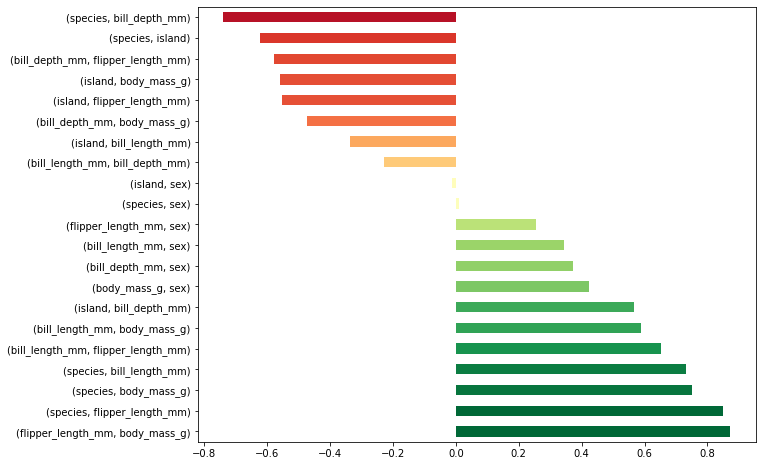

In [12]:
columns = list(df.columns)
correlation_plot = get_correlations(df[columns])

fig = plt.figure(figsize=(10, 8))
norm = TwoSlopeNorm(vmin=-.8, vcenter=0, vmax=.8)
colors = [plt.cm.RdYlGn(norm(c)) for c in correlation_plot.values]
correlation_plot.plot.barh(color=colors)
plt.show()

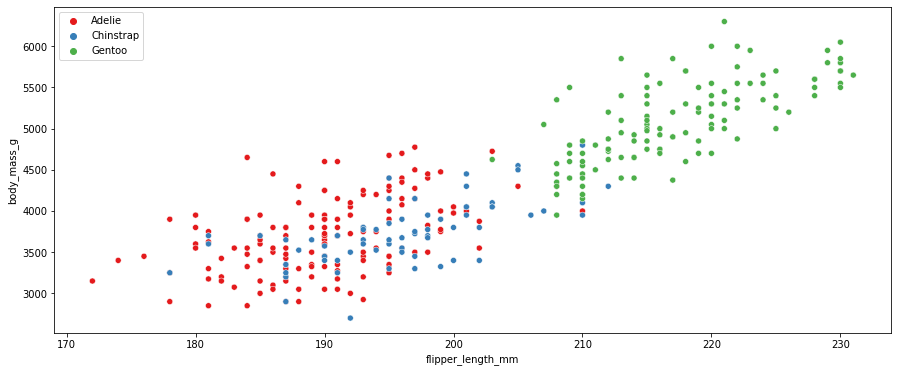

In [13]:
species_labels = {0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}
fig, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x="flipper_length_mm", y="body_mass_g", data=df.assign(Species=df["species"].map(species_labels)), hue="Species", palette="Set1")
ax.legend(loc='upper left')
plt.show()

Split the target and features variables

In [14]:
X = df.drop("species", axis=1)
y = pd.DataFrame(df["species"]).copy()

Split the data into the train and test set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Model Training

In this project, we are going to build a pipeline that will scale the features using standard scaler, then fit the data into a LightGBM classifier

Define the scaler

In [16]:
scaler = StandardScaler()

Define the classifier

In [17]:
clf = LGBMClassifier()

Create the pipeline

In [18]:
pipeline = Pipeline([
    ("scaler", scaler),
    ("method", clf)
])

In [19]:
pipeline.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('scaler', StandardScaler()), ('method', LGBMClassifier())])

In [46]:
y_train_pred = pipeline.predict(X_train)
print(f"Model accuracy on the training set : {round(accuracy_score(y_train, y_train_pred) * 100)}%")

Model accuracy on the training set : 100%


Evaluate the cross validation score

In [21]:
cross_val = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=cross_val)

In [22]:
print("CV scores:")
for count, item in enumerate(cv_scores):
    print(f"Fold {count}: {item:.3f}")

print(f"Mean: {cv_scores.mean():.3f}, Deviation: {cv_scores.std():.3f}")

CV scores:
Fold 0: 1.000
Fold 1: 1.000
Fold 2: 1.000
Fold 3: 1.000
Fold 4: 1.000
Fold 5: 1.000
Fold 6: 0.957
Fold 7: 0.957
Fold 8: 0.957
Fold 9: 1.000
Mean: 0.987, Deviation: 0.020


In [23]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        85

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233



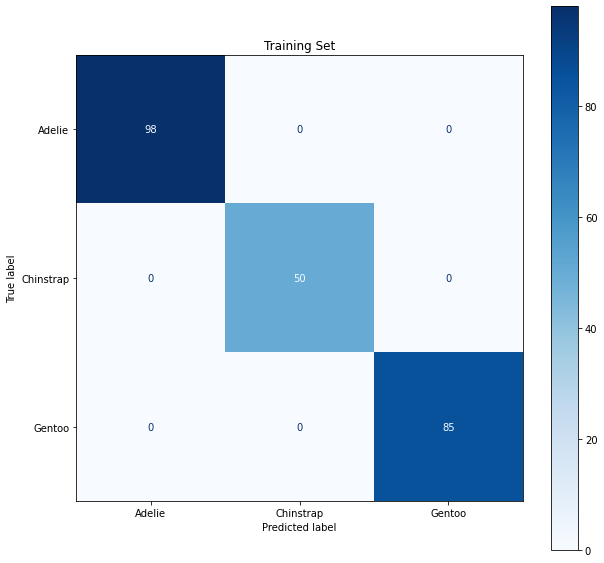

In [24]:
conf_mat_train = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Training Set')
conf_mat_train.plot(cmap=plt.cm.Blues, ax=ax)
ax.xaxis.set_ticklabels(list(species_labels.values()))
ax.yaxis.set_ticklabels(list(species_labels.values()))
plt.show()

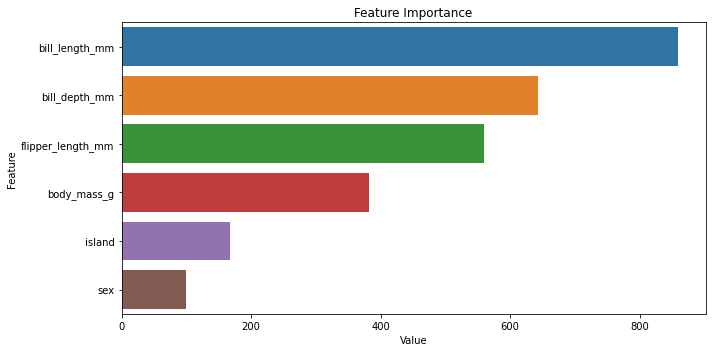

In [34]:
feature_imp = pd.DataFrame(sorted(zip(pipeline.named_steps["method"].feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

## Model Evaluation

In [37]:
y_test_pred = pipeline.predict(X_test)
print(f"Model accuracy on the training set : {round(accuracy_score(y_test, y_test_pred) * 100)}%")

Model accuracy on the training set : 99%


In [27]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       1.00      0.94      0.97        18
           2       1.00      1.00      1.00        34

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100



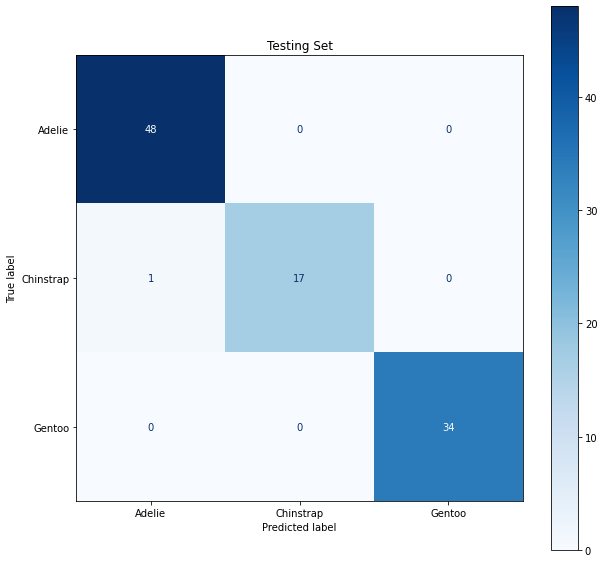

In [28]:
conf_mat_train = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Testing Set')
conf_mat_train.plot(cmap=plt.cm.Blues, ax=ax)
ax.xaxis.set_ticklabels(list(species_labels.values()))
ax.yaxis.set_ticklabels(list(species_labels.values()))
plt.show()

## Conclusion

In this project, we have build the model that able to classify penguin by its species.